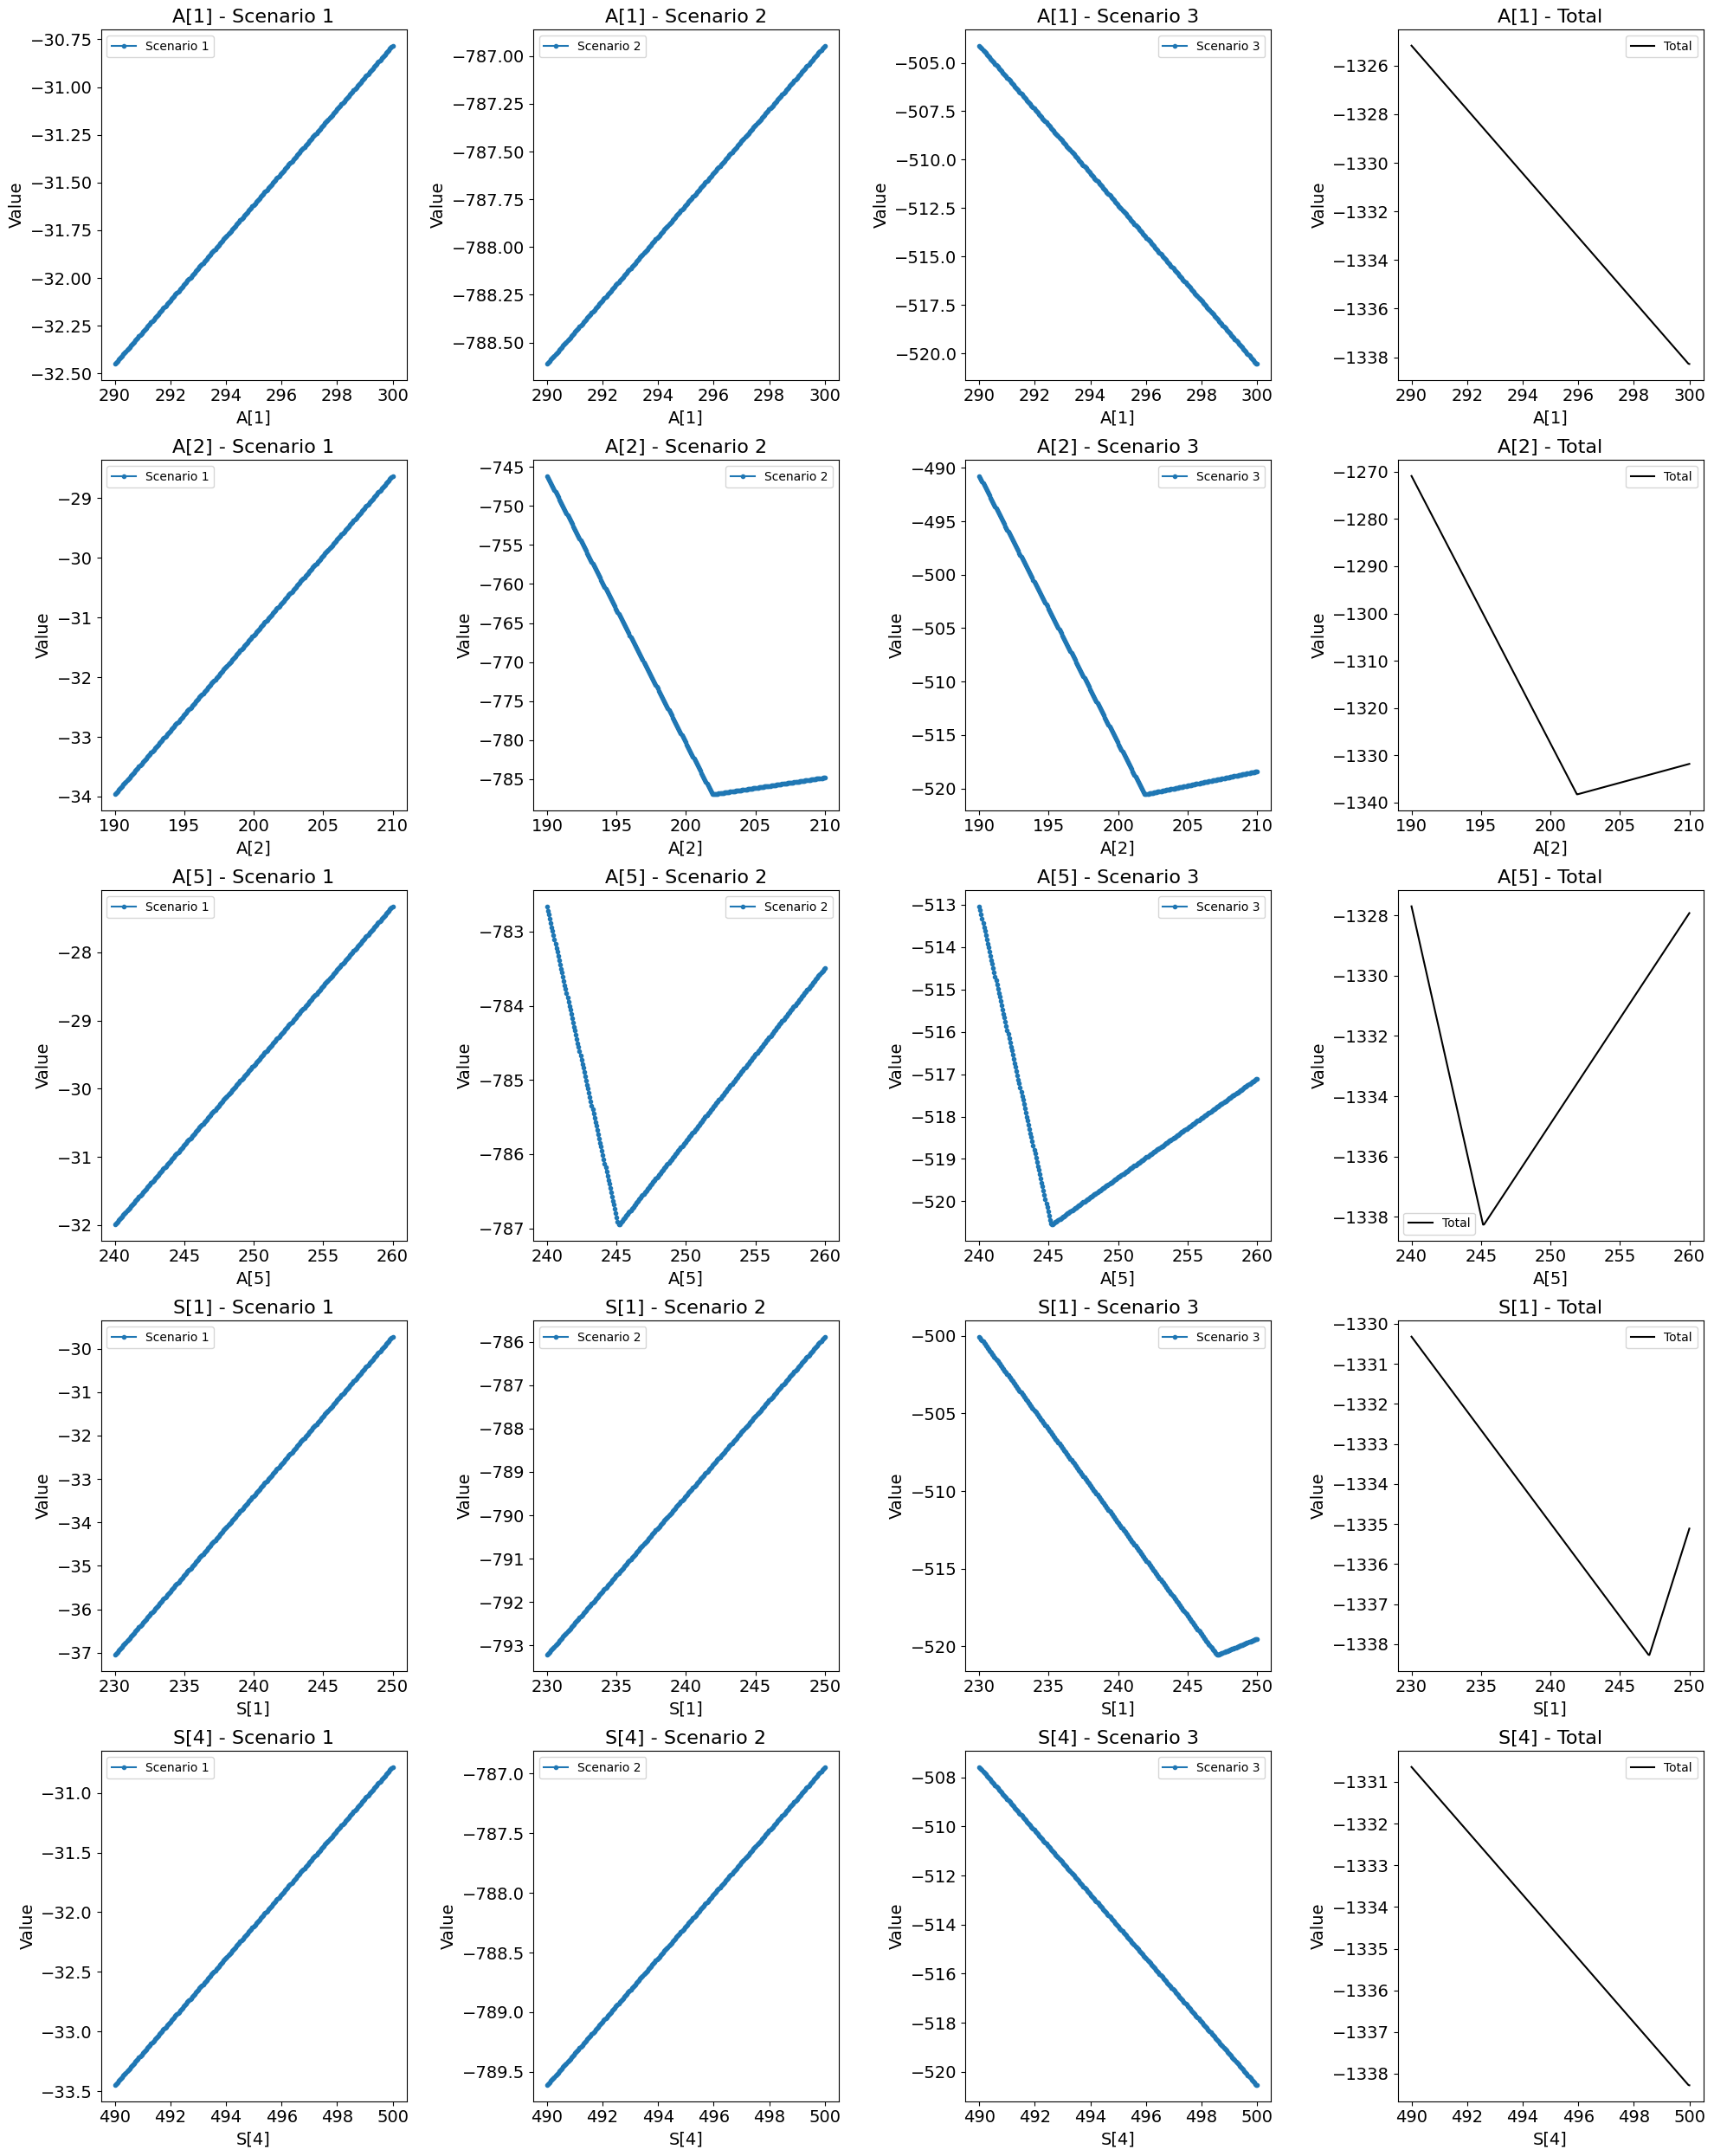

In [1]:
from src.models.cz_model import CaoZavalaModel, CaoZavalaAlgo
from NSPLIB.src.instances.pooling_contract_selection.pooling import const_model
from graphing.value_function.plotting import plotting
# Constants
pooling_obj = -1338.2471283376406
pooling_sol = {
    'A[1]': 300.0, 'A[2]': 201.92127476313524, 'A[3]': 0.0, 'A[4]': 0.0, 'A[5]': 245.18105081826008,
    'S[1]': 247.10232558139526, 'S[2]': 0.0, 'S[3]': 0.0, 'S[4]': 500.0
}

pooling_y_bound = {
    'A[1]': [0, 300], 'A[2]': [0, 250], 'A[3]': [0, 0], 'A[4]': [0, 0], 'A[5]': [0, 300],
    'S[1]': [0, 400], 'S[2]': [0, 0], 'S[3]': [0, 0], 'S[4]': [0, 500]
}
pooling_y_bound = {
    'A[1]': [290, 300], 'A[2]': [190, 210], 'A[3]': [0, 0], 'A[4]': [0, 0], 'A[5]': [240, 260],
    'S[1]': [230, 250], 'S[2]': [0, 0], 'S[3]': [0, 0], 'S[4]': [490, 500]
}
# Build model
sto_m = const_model()
m = CaoZavalaModel.from_sto_m(sto_m)
m.build()

# Fix binary variables
binary_ys = ['lambd[1]', 'lambd[2]', 'lambd[3]', 'lambd[4]', 'lambd[5]', 'theta[1]', 'theta[2]', 'theta[3]', 'theta[4]']
binary_y_val = {y: 0 for y in binary_ys}
binary_y_val['lambd[1]'] = 1
binary_y_val['lambd[2]'] = 1
binary_y_val['lambd[5]'] = 1
binary_y_val['theta[1]'] = 1
binary_y_val['theta[4]'] = 1
m.fix_binary_y(binary_y_val)
# initialize dictionary to store the data for each dimension
y_dimension = {'A[1]':{}, 'A[2]':{}, 'A[5]':{}, 'S[1]':{}, 'S[4]':{}}
plotting(m, 50, y_dimension, pooling_sol, pooling_y_bound,pooling_obj)